## Classical Hopfield Network Demonstration on MNIST 

In [121]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

Some useful functions

In [122]:
# Useful functions
def IsScalar(x):
    if type(x) in (list, np.ndarray,):
        return False
    else:
        return True

def Thresh(x):
    if IsScalar(x):
        val = 1 if x>0 else -1
    else:
        val = np.ones_like(x)
        val[x<0] = -1.
        '''
        x < 0 This creates a boolean array of the same shape as x, where each element is True if the corresponding element in x is less than 0, and False otherwise.
        val[x < 0]: This selects the elements in val where the condition x < 0 is True
        = -1.: This assigns the value -1. to all selected elements.
        '''
    return val

def Hamming(x, y):
    '''
        d = Hamming(x,y)
        
        Hamming distance between two binary vectors x and y.
        It's the number of digits that differ.
        
        Inputs:
          x and y are arrays of binary vectors, and can be either {0,1} or {-1,1}
        
        Output:
          d is the number of places where the inputs differ
    '''
    d = []
    for xx, yy in zip(x,y):
        dd = 0.
        for xxx,yyy in zip(xx,yy):
            if xxx==1 and yyy!=1:
                dd += 1.
            elif yyy==1 and xxx!=1:
                dd += 1.
        d.append(dd)
    return d

def Perturb(x, p=0.1):
    '''
        y = Perturb(x, p=0.1)
        
        Apply binary noise to x. With probability p, each bit will be randomly
        set to -1 or 1.
        
        Inputs:
          x is an array of binary vectors of {-1,1}
          p is the probability of each bit being randomly flipped
        
        Output:
          y is an array of binary vectors of {-1,1}
    '''
    y = copy.deepcopy(x)
    for yy in y:
        for k in range(len(yy)):
            if np.random.rand()<p:
                yy[k] = Thresh(np.random.randint(2)*2-1)
    return y

In [123]:
class Hopfield_Net: #network class
    #init ialize network variables and memory
    def __init__(self,input):
        #patterns for network training / retrieval
        print(input.shape)
        self.memory = np.array(input)
        print(self.memory.shape)
        #single vs. multiple memories
        if  self.memory.size > 1:
            self.n = self.memory.shape[1] 
        else:
            self.n = len(self.memory)
        #network construction
        self.state = np.random.randint(-2,2,(self.n,1)) #state vector
        self.weights = np.zeros((self.n,self.n)) #weights vector
        self.energies = [] #container for tracking of energy
    
    def insert_state(self,new_state):
        #self.state=new_state
        self.state=copy.deepcopy(new_state)

    def network_learning(self): #learn the pattern / patterns
        #self.weights = (1 / self.memory.shape[0]) * self.memory.T @ self.memory #hebbian learning
        #np.fill_diagonal(self.weights,0)
        self.weights = ( self.memory.T @ self.memory ) / np.shape(self.memory)[0] - np.eye(np.shape(self.memory)[1]) 

    def update_network_state(self,n_update): #update network
        for neuron in range(n_update): #update n neurons randomly
            self.rand_index = np.random.randint(0,self.n) #pick a random neuron in the state vector
            #Compute activation for randomly indexed neuron
            self.index_activation = np.dot(self.weights[self.rand_index,:],self.state) 
            #threshold function for binary state change
            if self.index_activation < 0: 
                self.state[self.rand_index] = -1
            else:
                self.state[self.rand_index] =  1

    def compute_energy(self): #compute energy
        self.energy = -0.5*np.dot(np.dot(self.state.T,self.weights),self.state)
        self.energies.append(self.energy)

Read the csv MNIST data

In [124]:
# Load the data
df = pd.read_csv('./mnist_test.csv',skiprows=1)

# Function to sample with handling for labels with fewer than 10 samples
def safe_sample(group, n):
    if len(group) < n:
        return group
    return group.sample(n=n, random_state=1)

# Group by the first column (label) and sample 10 entries for each label (if available)
#sampled_df = df.groupby(df.columns[0]).apply(lambda x: safe_sample(x, n=1)).reset_index(drop=True)
sampled_df = df.groupby(df.columns[0], group_keys=False).apply(lambda x: safe_sample(x, n=1)).reset_index(drop=True)
sampled_df = sampled_df.drop(columns=[df.columns[0]])

X = sampled_df.values
X = np.where(X>20, 1,-1)
print(len(X))

10


/tmp/ipykernel_341117/379460863.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(df.columns[0], group_keys=False).apply(lambda x: safe_sample(x, n=1)).reset_index(drop=True)


In [125]:
#def transform_pattern(pattern):
#    return np.repeat(pattern, 4)
#
#transformed_data = np.array([transform_pattern(row) for row in X])
#X=transformed_data

def upscale_image_nn(image, scale_factor):
    original_height, original_width = image.shape
    new_height, new_width = original_height * scale_factor, original_width * scale_factor

    # Create an empty array for the upscaled image
    upscaled_image = np.zeros((new_height, new_width))

    # Fill the upscaled image using nearest-neighbor interpolation
    for i in range(new_height):
        for j in range(new_width):
            # Find the nearest pixel in the original image
            original_i = i // scale_factor
            original_j = j // scale_factor
            upscaled_image[i, j] = image[original_i, original_j]

    return upscaled_image

a=0
image_arr=[]
while a<len(X):
    shape=len(X[a])
    image=X[a].reshape(int(np.sqrt(len(X[a]))),int(np.sqrt(len(X[a]))))
    image=upscale_image_nn(image,2)
    image=image.reshape(-1)
    #print(image.shape)
    #print(X[a].shape)
    image_arr.append(image)
    #X[a]=copy.deepcopy(image)
    a+=1
#print(X.shape)
print(X.shape)
image_arr=np.array(image_arr)
print(image_arr.shape)
X=image_arr


(10, 784)
(10, 3136)


(3136, 1)
(3136,)


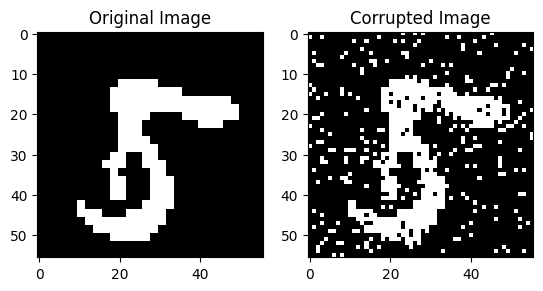

In [126]:
# Perturbed memory
def add_corruption(X_orig):
    x = copy.deepcopy(X_orig)
    k = np.random.randint(len(x)) #selects one of the row to test the network against
    Y = Perturb(x,p=0.2) # corrupts the selected row data
    x = Y[k:k+1,]
    err = Hamming(x,X_orig[k:k+1,:]) # checks the error between corrupted and correct data
    #print('Class '+str(k)+' with '+str(err)+' errors')
    return x.T,k

X_new=X[4:6]

x_corrupt,k=add_corruption(X_new)

print(x_corrupt.shape)
print(X_new[k].shape)
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(X_new[k].reshape(int(np.sqrt(len(X_new[k]))),int(np.sqrt(len(X_new[k])))), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Corrupted Image")
plt.imshow(x_corrupt.reshape(int(np.sqrt(len(x_corrupt))),int(np.sqrt(len(x_corrupt)))), cmap='gray')


2
1
(2, 3136)
(2, 3136)


(3136, 1)


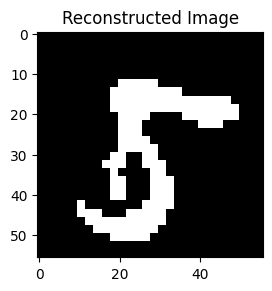

In [127]:
print(len(X_new))
print(k)
#H_Net = Hopfield_Net(np.array([X[k]]))
H_Net = Hopfield_Net(X_new)
H_Net.network_learning()
H_Net.insert_state(x_corrupt)
H_Net.update_network_state(64000) #6400000
H_Net.compute_energy()
plt.subplot(1, 2, 1)
plt.title("Reconstructed Image")
#ri=H_Net.state
cells = H_Net.state.reshape(int(np.sqrt(len(X_new[k]))),int(np.sqrt(len(X_new[k]))))
print(H_Net.state.shape)
plt.imshow(cells, cmap='gray')

In [128]:
print("test")

test
